#### Vamos a hacer un _mixed_ recommendation system, en el que simplemente se hacen $k$ recomendaciones de cada uno, y se combinan las dos listas para obtener $k$ recomendaciones.

- Si un item está en las dos listas, se escoge sí o sí (sin importar su posición en la lista)
- Los huecos restantes se rellenan con un item de cada lista alternativamente

Es decir, si R1 recomienda {A,B,C,D,E} y R2 recomienda {A,D,F,G,H,I}, el recomendador mixto recomendaría {A,D,B,F,C}. A y D se recomiendan porque están en ambas, y luego se recomendaría el restante de cada uno.

In [1]:
from pathlib import Path
import itertools as it

import pandas as pd
import numpy as np

from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt

from src.datasets import daocensus, to_microsoft
from src.models.nlp import NLPModel, NLPSimilarity

%load_ext autoreload
%autoreload 2

/tmp/ipykernel_3246947/2154055756.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-01-16 11:12:07.311642: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 11:12:07.311664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 11:12:07.311680: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ORG_NAME = 'Decentraland'
SPLITS_FREQ = '1W'
SEED: int = 42
K_RECOMMENDATIONS = [5, 10]

# To evaluate the hybrid recommender system
MERGE_FUNC = 'naive' # one of 'avg', 'naive', 'prioritize'
BEST_HPARAMS_FILE = Path(f"./data/baseline/best-{ORG_NAME}-{SPLITS_FREQ}.csv")
REALISTIC_HPARAMS_FILE = Path(f"./data/baseline/realistic-{ORG_NAME}-{SPLITS_FREQ}.csv")

# Reading the dataset

In [3]:
dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
dfv['voter'] = dfv['voter'].astype('str')
dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  object        
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(7)
memory usage: 8.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1942 entries, 1e570406-6963-530d-8f67-0a7686449f64 to 19a58960-27e4-54d2-b0ae-87e258c741c3
Data columns (total 13 column

In [4]:
from src.model_selection import timeFreqSplitCurrent

df = to_microsoft(dfv)
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'))
f = folds[0][0]
f

,userID,itemID,timestamp,rating
7636,0x361b9fbf20ed8de4b62cd5b0ccdf36face38bdc4,bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,2021-05-30 11:35:12,1
7637,0xd4a08cf067c83d1b2cc1d26831569b7850804be7,bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,2021-05-30 09:35:44,1
7638,0x4d29b7f953ba471fb650fc5842127b05e35949b5,bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,2021-05-30 08:26:26,1
7639,0x1ca5e86a1a7a88645dfe163071367a317c9033e4,bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,2021-05-30 06:06:42,1
7640,0x2c8f6c836d4c1f778958b5c26234dac5afd6e11f,bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,2021-05-30 03:43:20,1
...,...,...,...,...
108178,0x8cff6832174091dae86f0244e3fd92d4ced2fe07,954eac50-670b-5b29-b2a9-f97bfbfab26b,2021-05-24 17:41:41,1
108179,0xec6e6c0841a2ba474e92bf42baf76bfe80e8657c,954eac50-670b-5b29-b2a9-f97bfbfab26b,2021-05-24 17:40:41,1
108180,0xe2b6024873d218b2e83b462d3658d8d7c3f55a18,954eac50-670b-5b29-b2a9-f97bfbfab26b,2021-05-24 17:40:40,1
108181,0xd210dc1dd26751503cbf1b8c9154224707820da8,954eac50-670b-5b29-b2a9-f97bfbfab26b,2021-05-24 17:37:43,1


# Creating the model

In [5]:
from src.models.hybrid import HybridRecommendation

lightgcn_config = dict(
    n_layers=3,
    batch_size=512,
    embed_size=64,
    epochs=2,
    learning_rate=0.001,
    decay=0.00001,
    metrics=[],
    eval_epoch=2,
    top_k=5,
    save_model=False,
    MODEL_DIR='/tmp/hybrid-model',
    cf_seed=SEED,
)

nlp_config = dict(
    # filter_window='14d',
)

hr = HybridRecommendation(folds[0][0], folds[0][1], dfp, lightgcn_config=lightgcn_config, nlp_config=nlp_config)
hr

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [6]:
hr.fit()

Epoch 1 (train)0.1s: train loss = 0.68068 = (mf)0.68067 + (embed)0.00002
Epoch 2 (train)0.0s + (eval)0.7s: train loss = 0.67907 = (mf)0.67905 + (embed)0.00002, 
All embeddings are already calculated


In [7]:
# hr.recommend_k_items(['0x29d5cea7d511810f3ff754886b898fce16a6d8fd', '0x30b1f4bd5476906f38385b891f2c09973196b742'], top_k=3)

In [8]:
train_users = set(folds[0][0]['userID'])
test_users = set(folds[0][1]['userID'])

in_test_not_in_train = test_users.difference(train_users)
assert in_test_not_in_train == set()

In [9]:
hr.recommend_k_items(folds[0][1]['userID'].unique(), top_k=3)

,userID,itemID,prediction,rec
0,0x0a7e606eb21c80c28a005daeb5f3d99a40d6b154,19a58960-27e4-54d2-b0ae-87e258c741c3,0,nlp
1,0x0a7e606eb21c80c28a005daeb5f3d99a40d6b154,ce382ef1-77c0-5262-9d7e-5b8daf2b18f6,0,gnn
2,0x0a7e606eb21c80c28a005daeb5f3d99a40d6b154,6d5c2fee-a0f6-5b98-813b-f7d9a5ab1b41,1,nlp
3,0x0a7e606eb21c80c28a005daeb5f3d99a40d6b154,741a35c6-04e2-5fa1-8426-d54d75c532c5,1,gnn
4,0x0a7e606eb21c80c28a005daeb5f3d99a40d6b154,68c0b3c5-4708-5659-9cc2-a44e721aa74a,2,nlp
...,...,...,...,...
150,0xec6e6c0841a2ba474e92bf42baf76bfe80e8657c,73e7f27f-b83b-5c8a-9e84-301fb8bed3b0,0,nlp
151,0xec6e6c0841a2ba474e92bf42baf76bfe80e8657c,7b7c6b51-3549-503a-8a19-0b7d912a0b84,0,gnn
152,0xec6e6c0841a2ba474e92bf42baf76bfe80e8657c,29f4e9ae-ed74-5b98-9eee-ea8335a150a6,1,nlp
153,0xec6e6c0841a2ba474e92bf42baf76bfe80e8657c,25281510-41ac-5a12-9200-33d99fcaffee,1,gnn


# Evaluating the model

In [10]:
hparams_df = pd.read_csv(BEST_HPARAMS_FILE, index_col=0)
hparams_df

,config/fold,config/iteration,loss,mf_loss,emb_loss,precision@5,ndcg@5,precision@10,ndcg@10,time_total_train,time_total_test,done,config/batch_size,config/embedding_dim,config/conv_layers,config/learning_rate,config/l2
0,0,10,0.010209,0.010073,0.000136,0.223333,0.400848,0.195000,0.503982,52.248376,0.866580,True,128,300,4,0.0065,8.923120e-07
1,1,10,0.067471,0.066783,0.000689,0.279545,0.445733,0.245455,0.605004,65.118093,1.238513,True,128,215,3,0.0005,2.791926e-05
2,2,5,0.193591,0.188178,0.005413,0.234722,0.397458,0.202778,0.480621,4.275784,1.119803,False,512,5,3,0.2200,5.242816e-05
3,3,5,0.019303,0.019215,0.000088,0.266667,0.485198,0.208333,0.598285,28.306237,0.730749,False,128,300,4,0.0065,8.923120e-07
4,4,5,0.190009,0.184598,0.005411,0.286567,0.433946,0.238806,0.587374,5.973310,1.294290,False,512,5,3,0.2200,5.242816e-05
5,5,10,0.515156,0.402481,0.112674,0.275000,0.445371,0.230357,0.536457,8.684578,0.744998,True,256,30,5,0.2347,2.860601e-05
6,6,5,0.193592,0.188146,0.005446,0.273469,0.424544,0.240816,0.534517,3.178146,0.704453,False,512,5,3,0.2200,5.242816e-05
7,7,10,0.493711,0.379210,0.114501,0.265574,0.479723,0.206557,0.600991,14.305262,0.773311,True,256,30,5,0.2347,2.860601e-05
8,8,10,0.010232,0.010088,0.000143,0.277838,0.437099,0.252432,0.539334,63.536720,0.861269,True,128,300,4,0.0065,8.923120e-07
9,9,10,0.011145,0.011002,0.000143,0.227027,0.378828,0.182883,0.455322,77.722214,1.276523,True,128,300,4,0.0065,8.923120e-07


In [11]:
hparams_df['config/eval_epoch'] = -1
hparams_df['config/save_epoch'] = -1
hparams_df['config/top_k'] = 0
hparams_df['config/metrics'] = [ [] for x in range(len(hparams_df)) ]
hparams_df['config/MODEL_DIR'] = ''
hparams_df['config/save_model'] = False
# hparams_df['config/iteration'] = 2

config_cols = [ c for c in hparams_df.columns if c.startswith('config/') and c != 'config/fold' ]
lightgcn_configs = hparams_df[config_cols] \
    .rename(columns=lambda x: x.replace('config/', '')) \
    .rename(columns={
        'embedding_dim': 'embed_size',
        'conv_layers': 'n_layers',
        'l2': 'decay',
        'iteration': 'epochs',
    }) \
    .to_dict('records')
# nlp_configs = [ {'filter_window': '14d'} for _ in lightgcn_configs ]
nlp_configs = [ {} for _ in lightgcn_configs ]
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'))[-len(hparams_df):]

assert len(lightgcn_configs) == len(nlp_configs)
assert len(nlp_configs) == len(folds)

In [12]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from collections import defaultdict

metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 

metrics = defaultdict(list)
metrics_nlp = defaultdict(list)
metrics_gnn = defaultdict(list)

pct_metrics = defaultdict(list)
debug_metrics = defaultdict(list)

for (train, test, t, open_proposals), lightgcn_config, nlp_config in zip(tqdm(folds), lightgcn_configs, nlp_configs):
    #### SET UP MODEL
    model = HybridRecommendation(train, test, dfp, merge_func=MERGE_FUNC, seed=SEED, lightgcn_config=lightgcn_config, nlp_config=nlp_config)

    #### FIT MODEL
    model.fit()

    #### EVALUATE MODEL
    metrics['t'].append(t)
    metrics_nlp['t'].append(t)
    metrics_gnn['t'].append(t)
    
    for k_recs in K_RECOMMENDATIONS:
        recs = model.recommend_k_items(
            to_users=test['userID'].unique(),
            top_k=k_recs,
            recommend_from=open_proposals,
        )

        _pct = (recs.groupby('rec').size() / recs.groupby('rec').size().sum()) \
            .reindex(['both', 'gnn', 'nlp'], fill_value=0.0)

        for rec, v in _pct.to_dict().items():
            pct_metrics[(k_recs, rec)].append(v)

        _gby = pd.concat((model.nlp_recs, model.gnn_recs)).groupby('userID')['itemID']
        _pctDupes = ((_gby.size() - _gby.nunique())/k_recs).mean()
        debug_metrics[(k_recs, 'pctDupes')].append(_pctDupes)
        
        for m, f in metrics_f.items():
            metrics[m+f'@{k_recs}'].append(f(test, recs, k=k_recs))
            metrics_nlp[m+f'@{k_recs}'].append(f(test, model.nlp_recs, k=k_recs))
            metrics_gnn[m+f'@{k_recs}'].append(f(test, model.gnn_recs, k=k_recs))

  0%|          | 0/10 [00:00<?, ?it/s]

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)6.2s: train loss = 0.11447 = (mf)0.11445 + (embed)0.00003
Epoch 2 (train)6.1s: train loss = 0.04023 = (mf)0.04018 + (embed)0.00005
Epoch 3 (train)6.1s: train loss = 0.02899 = (mf)0.02892 + (embed)0.00006
Epoch 4 (train)6.0s: train loss = 0.02343 = (mf)0.02336 + (embed)0.00008
Epoch 5 (train)6.0s: train loss = 0.01845 = (mf)0.01836 + (embed)0.00009
Epoch 6 (train)6.0s: train loss = 0.01707 = (mf)0.01698 + (embed)0.00010
Epoch 7 (train)6.1s: train loss = 0.01438 = (mf)0.01427 + (embed)0.00011
Epoch 8 (train)5.9s: train loss = 0.01273 = (mf)0.01262 + (embed)0.00012
Epoch 9 (train)6.0s: train loss = 0.01164 = (mf)0.01151 + (embed)0.00013
Epoch 10 (train)6.0s: train loss = 0.01068 = (mf)0.01055 + (embed)0.00014
All embeddings are already calculated


/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)4.7s: train loss = 0.45418 = (mf)0.45410 + (embed)0.00008
Epoch 2 (train)4.1s: train loss = 0.23176 = (mf)0.23151 + (embed)0.00025
Epoch 3 (train)4.4s: train loss = 0.16635 = (mf)0.16601 + (embed)0.00035
Epoch 4 (train)4.5s: train loss = 0.13465 = (mf)0.13422 + (embed)0.00042
Epoch 5 (train)4.3s: train loss = 0.11691 = (mf)0.11643 + (embed)0.00048
Epoch 6 (train)4.2s: train loss = 0.09987 = (mf)0.09934 + (embed)0.00053
Epoch 7 (train)4.5s: train loss = 0.08844 = (mf)0.08786 + (embed)0.00058
Epoch 8 (train)4.2s: train loss = 0.07905 = (mf)0.07843 + (embed)0.00062
Epoch 9 (train)4.4s: train loss = 0.07225 = (mf)0.07160 + (embed)0.00066
Epoch 10 (train)4.4s: train loss = 0.06539 = (mf)0.06470 + (embed)0.00069
All embeddings are already calculated


/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)0.6s: train loss = 0.17188 = (mf)0.16975 + (embed)0.00213
Epoch 2 (train)0.4s: train loss = 0.17308 = (mf)0.16950 + (embed)0.00357
Epoch 3 (train)0.6s: train loss = 0.18258 = (mf)0.17825 + (embed)0.00432
Epoch 4 (train)0.4s: train loss = 0.18640 = (mf)0.18154 + (embed)0.00486
Epoch 5 (train)0.4s: train loss = 0.20062 = (mf)0.19534 + (embed)0.00528
All embeddings are already calculated


/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)6.7s: train loss = 0.11341 = (mf)0.11338 + (embed)0.00003
Epoch 2 (train)6.5s: train loss = 0.04208 = (mf)0.04204 + (embed)0.00005
Epoch 3 (train)6.5s: train loss = 0.02893 = (mf)0.02887 + (embed)0.00006
Epoch 4 (train)6.7s: train loss = 0.02274 = (mf)0.02266 + (embed)0.00008
Epoch 5 (train)6.5s: train loss = 0.01923 = (mf)0.01915 + (embed)0.00009
All embeddings are already calculated


/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)0.6s: train loss = 0.17193 = (mf)0.16977 + (embed)0.00217
Epoch 2 (train)0.4s: train loss = 0.17121 = (mf)0.16757 + (embed)0.00364
Epoch 3 (train)0.4s: train loss = 0.18470 = (mf)0.18030 + (embed)0.00439
Epoch 4 (train)0.5s: train loss = 0.18435 = (mf)0.17947 + (embed)0.00488
Epoch 5 (train)0.5s: train loss = 0.19017 = (mf)0.18487 + (embed)0.00530
All embeddings are already calculated


/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)1.2s: train loss = 0.12632 = (mf)0.11552 + (embed)0.01080
Epoch 2 (train)1.4s: train loss = 0.24834 = (mf)0.21696 + (embed)0.03139
Epoch 3 (train)1.3s: train loss = 0.31047 = (mf)0.26140 + (embed)0.04907
Epoch 4 (train)1.2s: train loss = 0.38145 = (mf)0.31834 + (embed)0.06311
Epoch 5 (train)1.0s: train loss = 0.43736 = (mf)0.36277 + (embed)0.07459
Epoch 6 (train)1.4s: train loss = 0.46994 = (mf)0.38466 + (embed)0.08528
Epoch 7 (train)1.3s: train loss = 0.44668 = (mf)0.35276 + (embed)0.09393
Epoch 8 (train)1.4s: train loss = 0.49625 = (mf)0.39479 + (embed)0.10146
Epoch 9 (train)1.6s: train loss = 0.52315 = (mf)0.41480 + (embed)0.10835
Epoch 10 (train)1.2s: train loss = 0.47757 = (mf)0.36320 + (embed)0.11437
All embeddings are already calculated


/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)0.6s: train loss = 0.17533 = (mf)0.17320 + (embed)0.00213
Epoch 2 (train)0.4s: train loss = 0.17296 = (mf)0.16936 + (embed)0.00360
Epoch 3 (train)0.5s: train loss = 0.18174 = (mf)0.17734 + (embed)0.00439
Epoch 4 (train)0.5s: train loss = 0.19049 = (mf)0.18550 + (embed)0.00499
Epoch 5 (train)0.5s: train loss = 0.19894 = (mf)0.19354 + (embed)0.00541
All embeddings are already calculated


/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)1.3s: train loss = 0.13509 = (mf)0.12420 + (embed)0.01089
Epoch 2 (train)1.5s: train loss = 0.23414 = (mf)0.20361 + (embed)0.03052
Epoch 3 (train)1.2s: train loss = 0.30634 = (mf)0.25765 + (embed)0.04869
Epoch 4 (train)1.0s: train loss = 0.37646 = (mf)0.31276 + (embed)0.06370
Epoch 5 (train)1.2s: train loss = 0.42067 = (mf)0.34495 + (embed)0.07572
Epoch 6 (train)1.2s: train loss = 0.46610 = (mf)0.38025 + (embed)0.08585
Epoch 7 (train)1.4s: train loss = 0.47514 = (mf)0.38035 + (embed)0.09479
Epoch 8 (train)1.2s: train loss = 0.46265 = (mf)0.36029 + (embed)0.10236
Epoch 9 (train)1.3s: train loss = 0.52073 = (mf)0.41184 + (embed)0.10889
Epoch 10 (train)1.1s: train loss = 0.52754 = (mf)0.41307 + (embed)0.11448
All embeddings are already calculated


/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)7.1s: train loss = 0.11455 = (mf)0.11452 + (embed)0.00003
Epoch 2 (train)6.9s: train loss = 0.04297 = (mf)0.04292 + (embed)0.00005
Epoch 3 (train)6.7s: train loss = 0.02929 = (mf)0.02922 + (embed)0.00007
Epoch 4 (train)6.7s: train loss = 0.02264 = (mf)0.02256 + (embed)0.00008
Epoch 5 (train)6.7s: train loss = 0.01894 = (mf)0.01885 + (embed)0.00009
Epoch 6 (train)7.0s: train loss = 0.01556 = (mf)0.01546 + (embed)0.00010
Epoch 7 (train)6.9s: train loss = 0.01492 = (mf)0.01481 + (embed)0.00011
Epoch 8 (train)6.9s: train loss = 0.01261 = (mf)0.01249 + (embed)0.00012
Epoch 9 (train)6.7s: train loss = 0.01104 = (mf)0.01090 + (embed)0.00013
Epoch 10 (train)7.1s: train loss = 0.01047 = (mf)0.01032 + (embed)0.00014
All embeddings are already calculated


/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)7.2s: train loss = 0.11119 = (mf)0.11116 + (embed)0.00003
Epoch 2 (train)6.9s: train loss = 0.04149 = (mf)0.04144 + (embed)0.00005
Epoch 3 (train)7.0s: train loss = 0.02846 = (mf)0.02839 + (embed)0.00007
Epoch 4 (train)7.0s: train loss = 0.02298 = (mf)0.02290 + (embed)0.00008
Epoch 5 (train)6.9s: train loss = 0.01890 = (mf)0.01881 + (embed)0.00009
Epoch 6 (train)7.0s: train loss = 0.01508 = (mf)0.01498 + (embed)0.00010
Epoch 7 (train)7.0s: train loss = 0.01422 = (mf)0.01411 + (embed)0.00011
Epoch 8 (train)7.0s: train loss = 0.01299 = (mf)0.01287 + (embed)0.00012
Epoch 9 (train)7.0s: train loss = 0.01134 = (mf)0.01120 + (embed)0.00013
Epoch 10 (train)7.0s: train loss = 0.01052 = (mf)0.01037 + (embed)0.00014
All embeddings are already calculated


In [13]:
model.gnn_recs

,userID,itemID,prediction,rec
0,0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,fdb1266c-f639-5b82-b65e-01b0b8493b38,6.037654,gnn
1,0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,7cdb2008-19a3-5e6c-a0d8-a1c4d59450da,5.853726,gnn
2,0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,ca79ba6b-5bf9-5df6-b645-8c3fa86df0a5,4.735919,gnn
3,0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,0b095940-bbd8-5027-be94-7011312011bc,3.941569,gnn
4,0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,93554c84-18ed-598d-af0a-4fb4569d335d,3.334090,gnn
...,...,...,...,...
2215,0xb45714bd67b88a178b19bd813e85b36eb0683e10,b83b029d-eed6-595f-8570-83fedf331602,1.401134,gnn
2216,0xb45714bd67b88a178b19bd813e85b36eb0683e10,5b056bd5-9e23-53e4-867a-0c88396e1a4e,1.106776,gnn
2217,0xb45714bd67b88a178b19bd813e85b36eb0683e10,e5fcfaed-fd89-547f-aba0-b682b2114a4b,1.024073,gnn
2218,0xb45714bd67b88a178b19bd813e85b36eb0683e10,390c1db9-bdca-5c44-9b62-c6683c536d11,0.662687,gnn


In [14]:
{ k:len(v) for k, v in pct_metrics.items() }

{(5, 'both'): 10,
 (5, 'gnn'): 10,
 (5, 'nlp'): 10,
 (10, 'both'): 10,
 (10, 'gnn'): 10,
 (10, 'nlp'): 10}

In [15]:
pct_metrics = pd.DataFrame(pct_metrics)
pct_metrics

5                             10                    
       both       gnn       nlp      both       gnn       nlp
0  0.458904  0.224315  0.316781  0.743151  0.126712  0.130137
1  0.604317  0.153477  0.242206  0.952038  0.033573  0.014388
2  0.369906  0.271160  0.358934  0.605016  0.159875  0.235110
3  0.392442  0.264535  0.343023  0.755814  0.113372  0.130814
4  0.504823  0.225080  0.270096  0.877814  0.070740  0.051447
5  0.277457  0.312139  0.410405  0.643545  0.138728  0.217726
6  0.266385  0.342495  0.391121  0.623679  0.198732  0.177590
7  0.479310  0.213793  0.306897  0.910345  0.027586  0.062069
8  0.257046  0.302142  0.440812  0.675310  0.078918  0.245772
9  0.273408  0.314607  0.411985  0.572097  0.186330  0.241573

In [16]:
debug_metrics = pd.DataFrame(debug_metrics)
debug_metrics.describe()

,5,10
,pctDupes,pctDupes
count,10.000000,10.000000
mean,0.420997,0.630909
std,0.113312,0.110377
min,0.310714,0.442361
25%,0.320937,0.550287
50%,0.388889,0.648194
75%,0.514969,0.696987
max,0.620455,0.789773


In [17]:
user = "0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf"

all_recs = pd.concat((model.nlp_recs, model.gnn_recs)).reset_index()
group = all_recs[all_recs["userID"] == user].set_index('userID').copy()

# display(group)
group.sort_values('rec', key=lambda s: group.groupby(s).cumcount())

,index,itemID,prediction,rec
userID,,,,
0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,0,21676de6-535a-5820-a7bb-b90e0f11b859,214.414703,nlp
0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,1,55ed051f-19ef-59c0-92e4-9244bb5d04d3,205.421844,nlp
0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,2,8b5b2496-3931-5917-8d68-a7bb18a1cbb5,200.718384,nlp
0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,3,a6351430-dcd5-58ad-8e29-ef4843a2aba1,196.392014,nlp
0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,4,ba58768c-007d-5506-9b99-c09587575adf,196.292633,nlp
0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,5,ca79ba6b-5bf9-5df6-b645-8c3fa86df0a5,192.031982,nlp
0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,6,0b095940-bbd8-5027-be94-7011312011bc,191.890030,nlp
0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,7,fdb1266c-f639-5b82-b65e-01b0b8493b38,191.863129,nlp
0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,8,f66a3484-cc8d-555e-9c53-0d59d2993541,190.010284,nlp


In [18]:
def _merge_apply_mean(group, top_k = 5):
    group['hyb_score'] = group.groupby('rec').cumcount()

    common = pd.DataFrame(index=group['itemID'][group['itemID'].duplicated(keep='first')])
    common['hyb_score'] = group.groupby('itemID')['hyb_score'].mean()
    common['prediction'] = common['hyb_score']
    common['rec'] = 'both'
    
    notcommon = group.drop_duplicates('itemID', keep=False).set_index('itemID')

    both = pd.concat((common, notcommon)).sort_values('hyb_score')
    both['prediction'] = top_k - both['hyb_score']

    return both.head(top_k)[['prediction', 'rec']]

merged_recs = all_recs.groupby('userID').apply(_merge_apply_mean).reset_index()
merged_recs

,userID,itemID,prediction,rec
0,0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34,390c1db9-bdca-5c44-9b62-c6683c536d11,5.0,nlp
1,0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34,ad105e76-a182-56b6-b30b-f4ea5e67fa0a,5.0,gnn
2,0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34,535f3065-a972-5679-83e9-752e31f3262c,4.0,gnn
3,0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34,bfc7adb9-a9cc-5b07-9c22-1b2825ca70b8,3.0,gnn
4,0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34,0b095940-bbd8-5027-be94-7011312011bc,2.5,both
...,...,...,...,...
1063,0xff1bccdd924de174d136bd427f498d49fbe32bf8,ca076ff5-a6b0-5fb8-9edf-e47bd1eb7f08,4.0,nlp
1064,0xff1bccdd924de174d136bd427f498d49fbe32bf8,e5fcfaed-fd89-547f-aba0-b682b2114a4b,3.5,both
1065,0xff1bccdd924de174d136bd427f498d49fbe32bf8,0b095940-bbd8-5027-be94-7011312011bc,3.5,both
1066,0xff1bccdd924de174d136bd427f498d49fbe32bf8,21676de6-535a-5820-a7bb-b90e0f11b859,1.0,nlp


In [19]:
merged_recs.value_counts('rec')

rec
both    459
nlp     308
gnn     301
dtype: int64

In [20]:
dfm_hyb = pd.DataFrame(metrics)
dfm_hyb['model'] = 'hybrid'
dfm_nlp = pd.DataFrame(metrics_nlp)
dfm_nlp['model'] = 'nlp'
dfm_gnn = pd.DataFrame(metrics_gnn)
dfm_gnn['model'] = 'gnn'

dfm_all = pd.concat((dfm_hyb, dfm_nlp, dfm_gnn)).set_index('t')
dfm_all.to_csv(f'./data/results/hybrid/{ORG_NAME}-{SPLITS_FREQ}.csv')
dfm_all.groupby('model').describe().T[['gnn', 'nlp', 'hybrid']]

model                     gnn        nlp     hybrid
precision@5  count  10.000000  10.000000  10.000000
             mean    0.262321   0.274235   0.268084
             std     0.025104   0.052818   0.037178
             min     0.228829   0.197222   0.213333
             25%     0.240030   0.229795   0.237500
             50%     0.264982   0.286308   0.270887
             75%     0.280544   0.305038   0.285181
             max     0.302273   0.361194   0.331343
ndcg@5       count  10.000000  10.000000  10.000000
             mean    0.427420   0.440005   0.433856
             std     0.039612   0.086198   0.062408
             min     0.368618   0.320561   0.328188
             25%     0.397985   0.363468   0.393543
             50%     0.423114   0.466465   0.428169
             75%     0.458349   0.478076   0.475013
             max     0.484479   0.596664   0.540047
map@5        count  10.000000  10.000000  10.000000
             mean    0.325742   0.335339   0.329821
             std     0.042662   0.076969   0.062471
             min     0.278053   0.222509   0.224158
             25%     0.297012   0.279384   0.298211
             50%     0.309944   0.354613   0.319990
             75%     0.358295   0.366956   0.363405
             max     0.390671   0.481541   0.439374
precision@10 count  10.000000  10.000000  10.000000
             mean    0.216211   0.217489   0.134042
             std     0.026333   0.032683   0.018589
             min     0.186486   0.168056   0.106667
             25%     0.194097   0.194266   0.118750
             50%     0.209675   0.220510   0.135444
             75%     0.241342   0.241388   0.142590
             max     0.251351   0.269189   0.165672
ndcg@10      count  10.000000  10.000000  10.000000
             mean    0.525731   0.530235   0.411046
             std     0.058346   0.088542   0.065340
             min     0.449564   0.385986   0.301349
             25%     0.470566   0.456136   0.379328
             50%     0.538621   0.550639   0.399121
             75%     0.574515   0.584232   0.437961
             max     0.607092   0.671346   0.530810
map@10       count  10.000000  10.000000  10.000000
             mean    0.408376   0.414974   0.329821
             std     0.052630   0.083388   0.062471
             min     0.335610   0.285442   0.224158
             25%     0.361919   0.354726   0.298211
             50%     0.413500   0.432180   0.319990
             75%     0.444935   0.464269   0.363405
             max     0.489007   0.554028   0.439374

In [21]:
dfm_all.groupby('model').mean().T[['gnn', 'nlp', 'hybrid']]

model,gnn,nlp,hybrid
precision@5,0.262321,0.274235,0.268084
ndcg@5,0.427420,0.440005,0.433856
map@5,0.325742,0.335339,0.329821
precision@10,0.216211,0.217489,0.134042
ndcg@10,0.525731,0.530235,0.411046
map@10,0.408376,0.414974,0.329821


Text(0.5, 1.0, 'ndcg@5 con merge=naive')

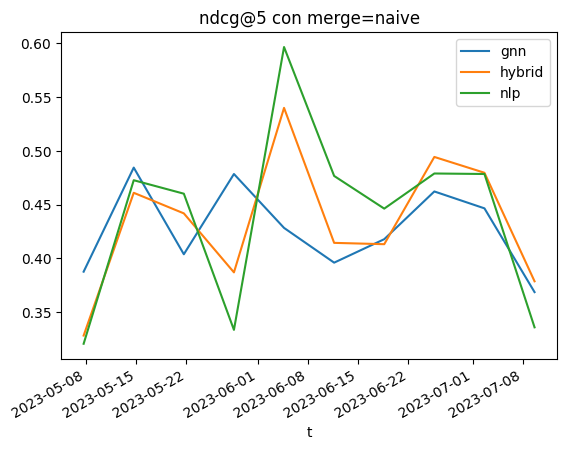

In [22]:
dfm_all.groupby('model')['ndcg@5'].plot(legend=True)
plt.title(f'ndcg@5 con merge={MERGE_FUNC}')

Text(0.5, 1.0, 'ndcg@10 con merge=naive')

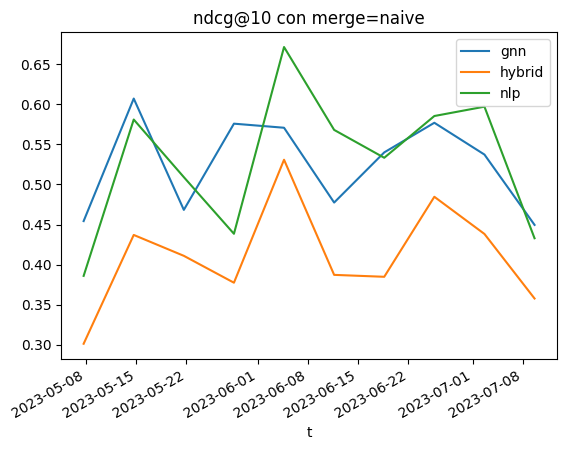

In [23]:
dfm_all.groupby('model')['ndcg@10'].plot(legend=True)
plt.title(f'ndcg@10 con merge={MERGE_FUNC}')

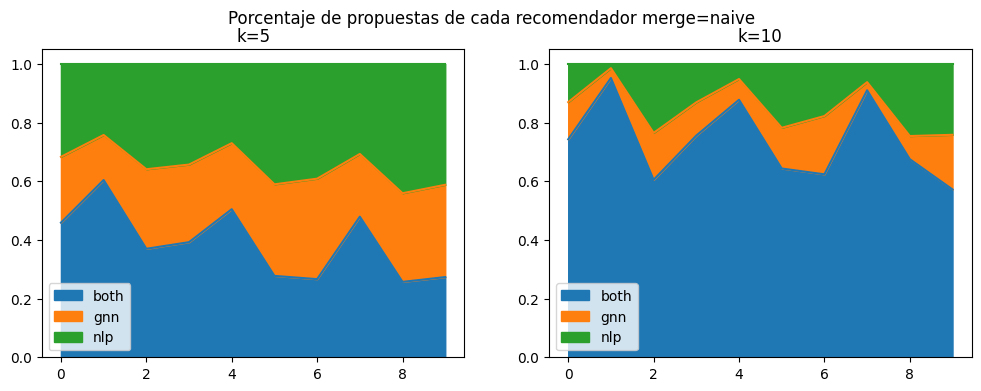

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
plt.suptitle(f'Porcentaje de propuestas de cada recomendador merge={MERGE_FUNC}')
for ax, k in zip(axes, [5,10]):
    pct_metrics[k].plot.area(ax=ax)
    ax.set_title(f'k={k}')

Text(0.5, 1.0, 'Porcentaje de elementos comunes entre los dos recsys')

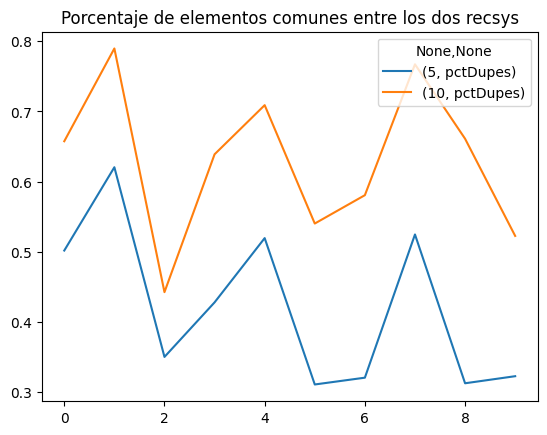

In [46]:
# TODO: Imprimir el porcentaje de propuestas duplicadas/exclusivas
# for k in debug_metrics.columns.get_level_values(0):
#     debug_metrics[k, 'pctExclusive'] = 1 - debug_metrics[k, 'pctDupes']
# debug_metrics = debug_metrics.sort_index(axis=1)

debug_metrics.plot()
plt.title("Porcentaje de elementos comunes entre los dos recsys")

In [25]:
model.nlp.recommend_k_items(
    to_users=test['userID'].unique(),
    top_k=5,
    recommend_from=open_proposals,
)

,userID,itemID,prediction
0,0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,21676de6-535a-5820-a7bb-b90e0f11b859,214.414703
1,0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,55ed051f-19ef-59c0-92e4-9244bb5d04d3,205.421844
2,0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,8b5b2496-3931-5917-8d68-a7bb18a1cbb5,200.718384
3,0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,a6351430-dcd5-58ad-8e29-ef4843a2aba1,196.392014
4,0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf,ba58768c-007d-5506-9b99-c09587575adf,196.292633
...,...,...,...
1063,0xb45714bd67b88a178b19bd813e85b36eb0683e10,ca076ff5-a6b0-5fb8-9edf-e47bd1eb7f08,6.603360
1064,0xb45714bd67b88a178b19bd813e85b36eb0683e10,0b095940-bbd8-5027-be94-7011312011bc,6.485958
1065,0xb45714bd67b88a178b19bd813e85b36eb0683e10,93554c84-18ed-598d-af0a-4fb4569d335d,6.347698
1066,0xb45714bd67b88a178b19bd813e85b36eb0683e10,858339c3-6902-52c5-ab98-bb5985327cbd,6.156612
